# Exploratory analysis
## Monetary Policy and Financial Stability frequency vs. economic indicators
## Bank of England and Federal Reserve speeches vs. economic indicators
## Speech frequency vs speech sentiment

In [1]:
# Import libaries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import warnings

# Ignore futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load the csv files for speech dates and CPI
speech_dates = pd.read_csv('speech_dates.csv')
cpi = pd.read_csv('cpi.csv')

In [3]:
# View the dataframes and info
print(speech_dates.head())
print(speech_dates.info())

          BoE         Fed         FSR MPR/Inflation report
0  15/09/1998  05/01/1997  06/12/2023           01/02/2024
1  21/10/1998  14/01/1997  12/07/2023           02/11/2023
2  21/10/1998  16/01/1997  13/12/2022           03/08/2023
3  01/11/1998  24/01/1997  05/07/2022           11/05/2023
4  01/11/1998  28/01/1997  13/12/2021           02/02/2023
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551 entries, 0 to 1550
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   BoE                   1209 non-null   object
 1   Fed                   1551 non-null   object
 2   FSR                   55 non-null     object
 3   MPR/Inflation report  125 non-null    object
dtypes: object(4)
memory usage: 48.6+ KB
None


In [4]:
# Simplify column names
speech_dates.rename(columns={'MPR/Inflation report': 'MPR'}, inplace=True)

In [5]:
print(cpi.head())
print(cpi.info())

         Date  CPI
0  01/01/1989  4.9
1  01/02/1989  5.0
2  01/03/1989  5.0
3  01/04/1989  5.3
4  01/05/1989  5.3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    422 non-null    object 
 1   CPI     422 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.7+ KB
None


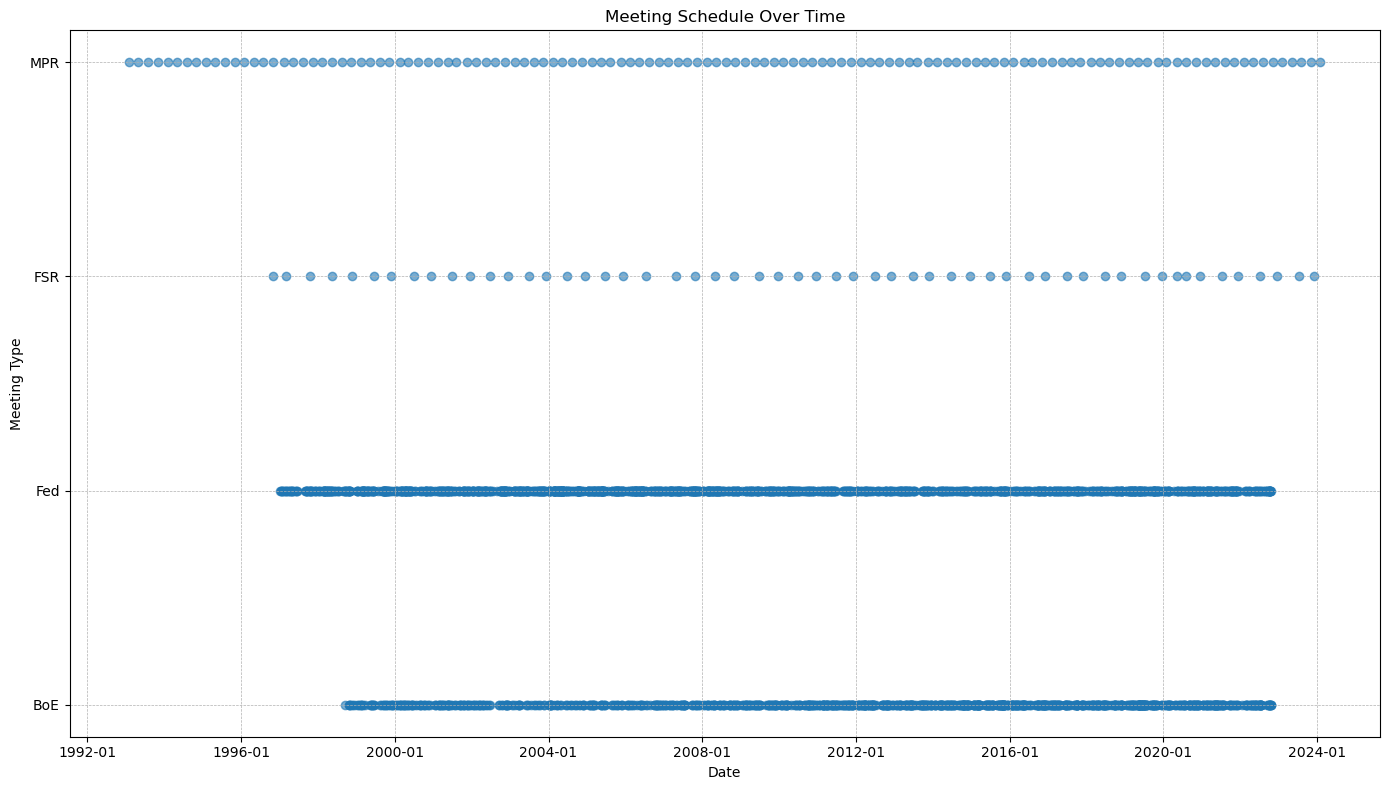

In [6]:
# Plot the frequency of meetings per month
# BoE = Bank of England speeches
# Fed = USA central bank speeches
# MPR = Monetary Policy Reports (including inflation report)
# FSR = Financial Stability Report

# Convert date columns to datetime format
speech_dates['BoE'] = pd.to_datetime(speech_dates['BoE'], dayfirst=True)
speech_dates['Fed'] = pd.to_datetime(speech_dates['Fed'], dayfirst=True)
speech_dates['FSR'] = pd.to_datetime(speech_dates['FSR'], dayfirst=True)
speech_dates['MPR'] = pd.to_datetime(speech_dates['MPR'], dayfirst=True)

# Create a long-format dataframe for plotting
dates_long = pd.melt(speech_dates, var_name='Meeting Type', value_name='Date')

# Assign numeric codes for each meeting type
meeting_types = dates_long['Meeting Type'].unique()
type_codes = {meeting_type: i + 1 for i, meeting_type in enumerate(meeting_types)}
dates_long['Type Code'] = dates_long['Meeting Type'].apply(lambda x: type_codes[x])

# Plot
plt.figure(figsize=(14, 8))
plt.scatter(dates_long['Date'], dates_long['Type Code'], alpha=0.6)

# Customize the plot
plt.title('Meeting Schedule Over Time')
plt.xlabel('Date')
plt.ylabel('Meeting Type')
plt.yticks(ticks=range(1, len(meeting_types) + 1), labels=meeting_types)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve date formatting on the x-axis
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()

# Save the figure
plt.savefig('meeting_timeline.png')

plt.show()


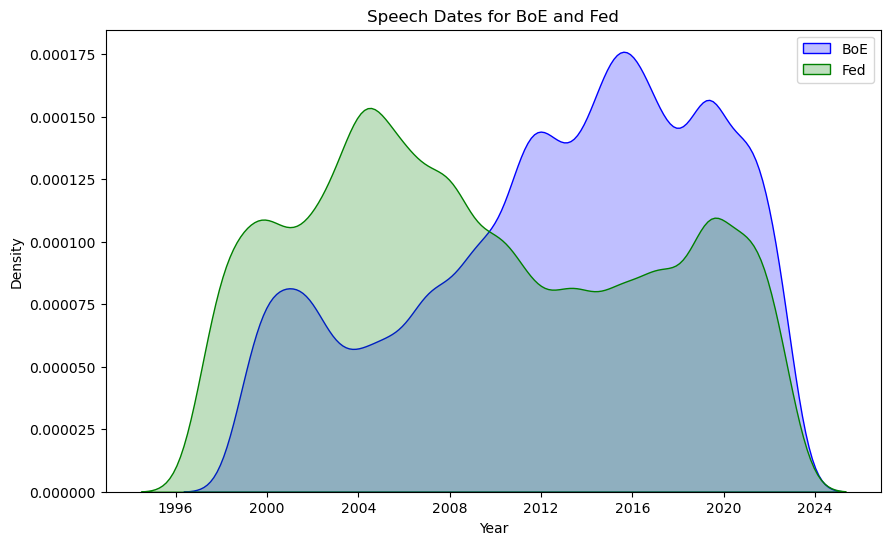

In [7]:
# Kernel Density Estimate for BoE and Fed dates

# Set the figure size
plt.figure(figsize=(10, 6))

# BoE KDE plot
sns.kdeplot(speech_dates['BoE'].dropna(), label='BoE', bw_adjust=0.5, color='blue', fill=True)
# Fed KDE plot
sns.kdeplot(speech_dates['Fed'].dropna(), label='Fed', bw_adjust=0.5, color='green', fill=True)

# Set title and labels
plt.title('Speech Dates for BoE and Fed')
plt.xlabel('Year')
plt.ylabel('Density')

# Show legend
plt.legend()

# Save the plot as an image
plt.savefig('speech_kde.png')

# Show the plot
plt.show()



In [8]:
# Define a function to plot a bar chart, taking 
# data, start and end dates as arguments

def plot_speeches(data, start_date, end_date):
    
    # Convert start and end dates to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Filter the data for the specified date range
    filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()
    
    # Extract year and month from the date for grouping
    filtered_data.loc[:, 'YearMonth'] = filtered_data['Date'].dt.to_period('M')
    
    # Group by category and year-month, then count the speeches
    speech_counts_filtered = filtered_data.groupby(['Meeting Type', 'YearMonth']).size().unstack(fill_value=0)
    
    # Plot
    fig, ax1 = plt.subplots(figsize=(14, 8))
    speech_counts_filtered.T.plot(kind='bar', ax=ax1, width=1, alpha=0.75)
    
    # Customize the primary y-axis
    ax1.set_title(f'Number of Speeches by Category and Month ({start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")})')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Number of Speeches')
    
    plt.tight_layout()
    plt.show()


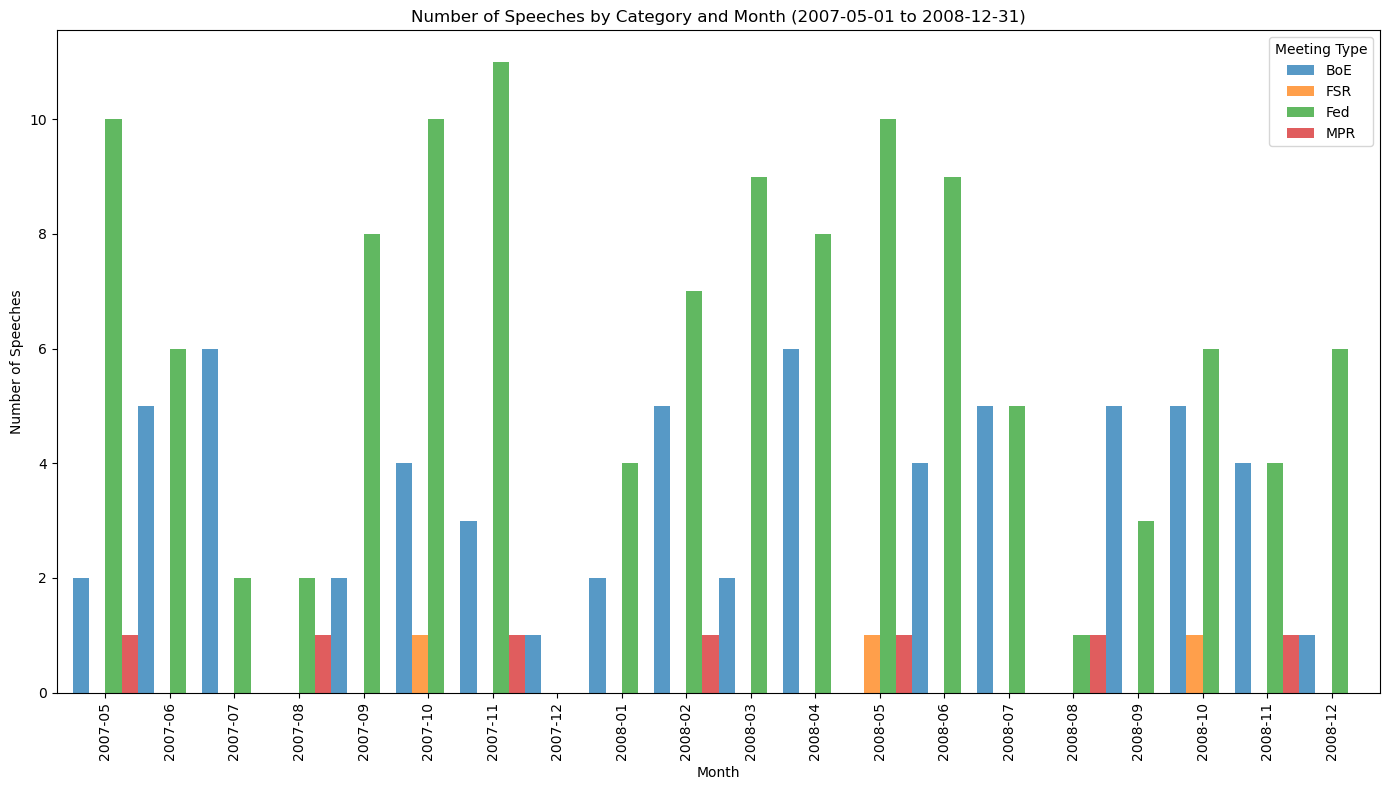

In [9]:
# Plot all the speaches for the  Global financial crisis period
plot_speeches(dates_long, '2007-05-01', '2008-12-31')

In [10]:
# Format the CPI data to allow plotting
# Change the date format and add a column for month
cpi['Date'] = pd.to_datetime(cpi['Date'], dayfirst=True)
cpi['YearMonth'] = cpi['Date'].dt.to_period('M')

# Aggregate CPI data by month (if there are multiple entries per month)
monthly_cpi = cpi.groupby('YearMonth')['CPI'].mean().reset_index()

In [11]:
# Define a function to plot speeches vs another measure, based on start/end etc.
def plot_speeches_vs(data, start_date, end_date, vs_data):
    
    # get the name of the vs_data column
    # assuming 2 column dataframe with date first
    vs = vs_data.columns[1]
    
    # Convert start and end dates to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Filter the vs data to match the speeches data date range
    vs_data_filtered = vs_data[(vs_data['YearMonth'].dt.to_timestamp() >= start_date) & 
                                 (vs_data['YearMonth'].dt.to_timestamp() <= end_date)]
    
    # Filter the speeches data for the specified date range
    filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()
    
    # Extract year and month from the date for grouping
    filtered_data['YearMonth'] = filtered_data['Date'].dt.to_period('M')
    
    # Group by category and year-month, then count the speeches
    speech_counts_filtered = filtered_data.groupby(['Meeting Type', 'YearMonth']).size().unstack(fill_value=0)
    
    # Plot speeches
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Convert YearMonth to strings for plotting
    speech_counts_filtered.columns = speech_counts_filtered.columns.astype(str)
    speech_counts_filtered.T.plot(kind='bar', ax=ax1, width=1, alpha=0.75)
    
    # Customize the primary y-axis
    ax1.set_title(f'Number of Speeches vs {vs} ({start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")})')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Number of Speeches')

    # Plot the vs data on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(vs_data_filtered['YearMonth'].astype(str), vs_data_filtered[vs], color='red', label=vs, linewidth=2)
    ax2.set_ylabel(vs, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
      
    # Set legends for both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    #ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    
    plt.tight_layout()
    
    # Generate filename based on start and end dates
    filename = f'speeches_{vs}_{start_date.strftime("%m%y")}_to_{end_date.strftime("%m%y")}.png'
    
    # Save the figure
    plt.savefig(filename)
    
    plt.show()

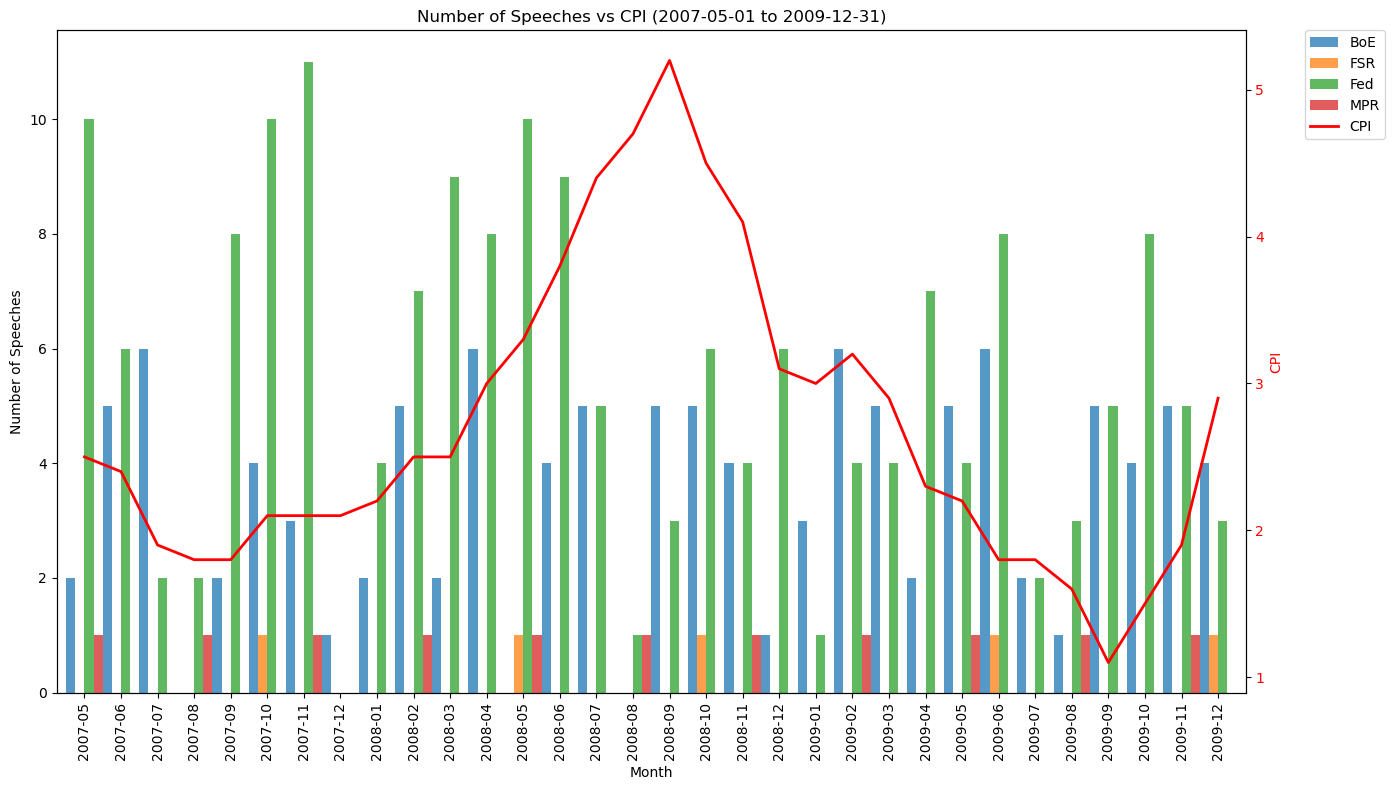

In [12]:
# CPI for Global financial crisis
plot_speeches_vs(dates_long, '2007-05-01', '2009-12-31', monthly_cpi)

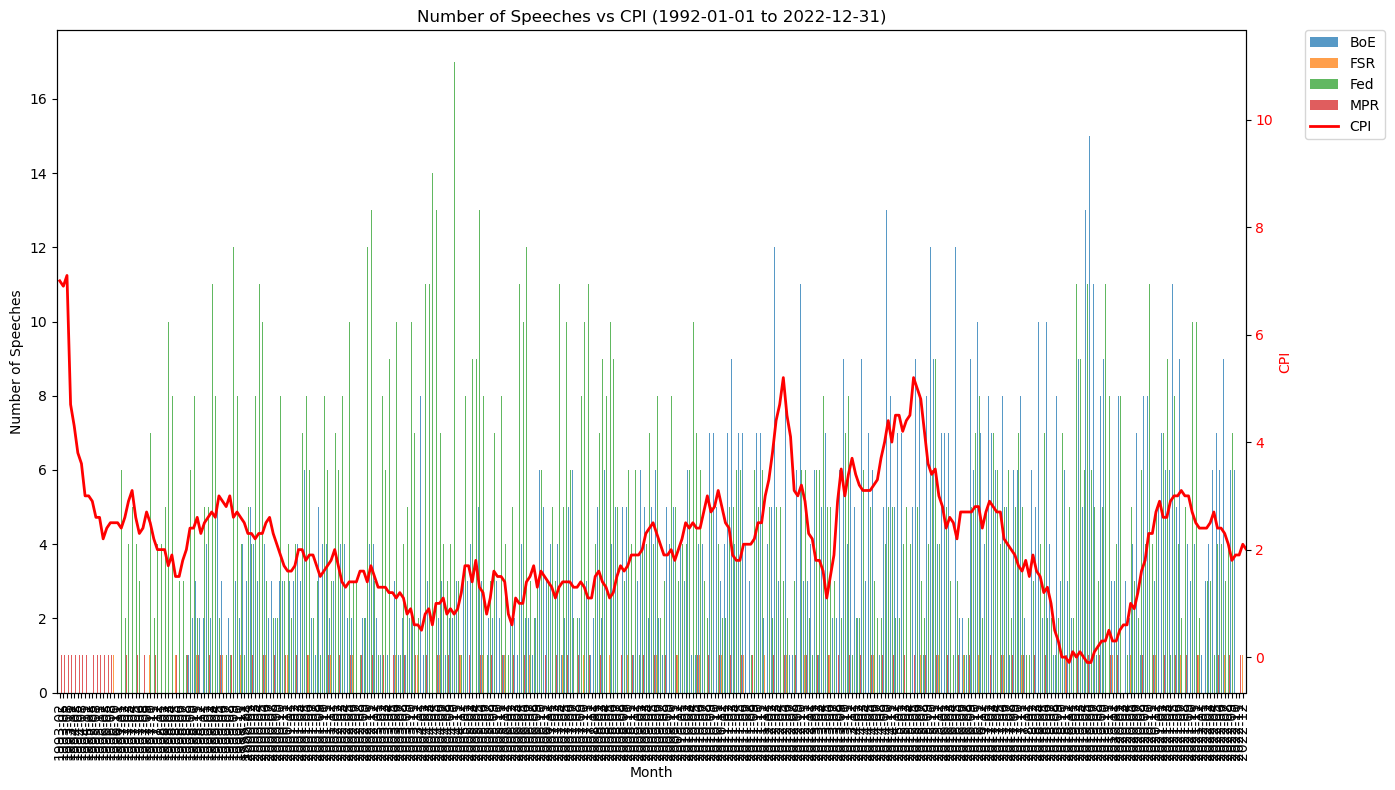

In [13]:
# CPI for Entire data period
plot_speeches_vs(dates_long, '1992-01-01', '2022-12-31', monthly_cpi)

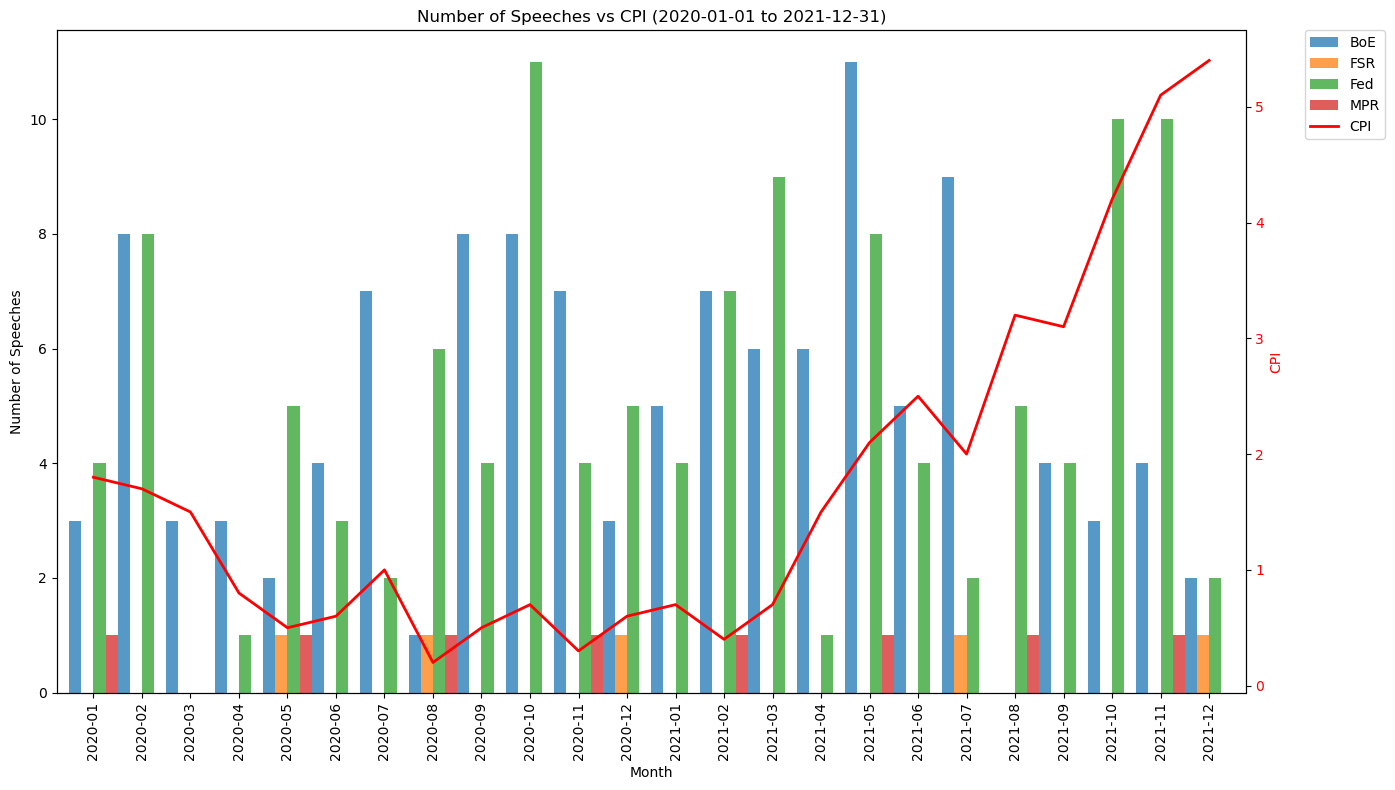

In [14]:
# CPI for Covid period
plot_speeches_vs(dates_long, '2020-01-01', '2021-12-31', monthly_cpi)

In [15]:
# Load the ftse data
ftse = pd.read_excel("ftse_gbp_1990_2024.xlsx")

# Display the dataframe
ftse.head()

,date,open,high,low,close,volume
0,1990-01-02,2425.500000,2443.300049,2425.500000,2434.100098,0
1,1990-01-03,2445.800049,2466.199951,2445.800049,2463.699951,0
2,1990-01-04,2463.699951,2479.399902,2451.600098,2451.600098,0
3,1990-01-05,2448.699951,2448.699951,2436.600098,2444.500000,0
4,1990-01-08,2444.500000,2445.600098,2423.800049,2431.300049,0


In [16]:
# Select only the 'date' and 'close' columns
ftse = ftse.loc[:, ['date', 'close']]
# Rename the columns
ftse = ftse.rename(columns={'date': 'Date', 'close': 'FTSE'})

# Display the dataframe
ftse.head()

,Date,FTSE
0,1990-01-02,2434.100098
1,1990-01-03,2463.699951
2,1990-01-04,2451.600098
3,1990-01-05,2444.500000
4,1990-01-08,2431.300049


In [17]:
# Format the data
ftse['Date'] = pd.to_datetime(ftse['Date'], dayfirst=True)
ftse['YearMonth'] = ftse['Date'].dt.to_period('M')

# Aggregate data by month (if there are multiple entries per month)
monthly_ftse = ftse.groupby('YearMonth')['FTSE'].mean().reset_index()

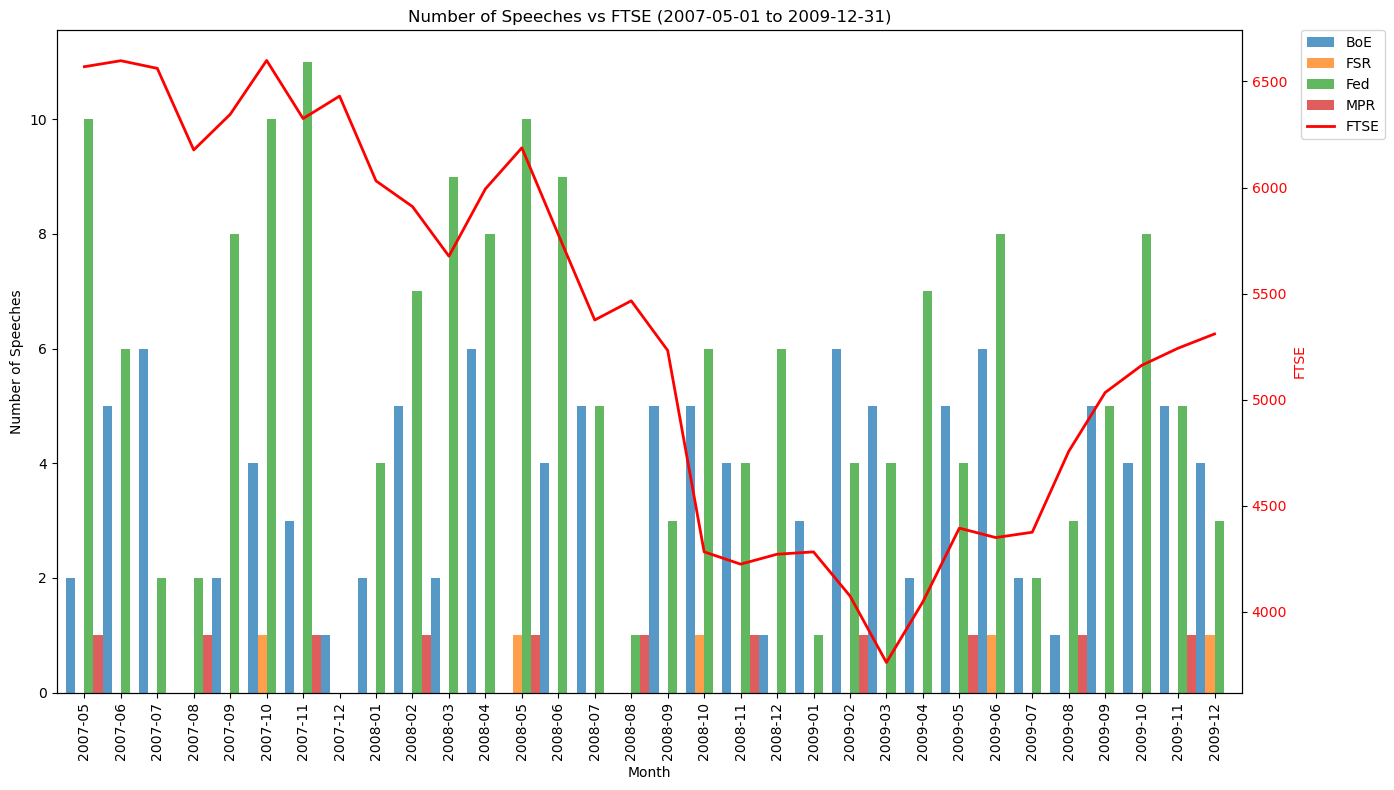

In [18]:
# Plot speech frequency with FTSE data for GFC period
plot_speeches_vs(dates_long, '2007-05-01', '2009-12-31', monthly_ftse)

In [19]:
# Load unemployment data
unemployment = pd.read_csv("Unemployment.csv")

# Display the dataframe
unemployment.head()

,Date,Unemployment %
0,1999-01-01,6.2
1,1999-02-01,6.1
2,1999-03-01,6.1
3,1999-04-01,6.1
4,1999-05-01,6.0


In [20]:
# Rename the columns
unemployment = unemployment.rename(columns={'Unemployment %': 'Unemployment'})
unemployment.head()

,Date,Unemployment
0,1999-01-01,6.2
1,1999-02-01,6.1
2,1999-03-01,6.1
3,1999-04-01,6.1
4,1999-05-01,6.0


In [21]:
# Format the data
unemployment['Date'] = pd.to_datetime(unemployment['Date'])
unemployment['YearMonth'] = unemployment['Date'].dt.to_period('M')

# Aggregate data by month (if there are multiple entries per month)
monthly_unemployment = unemployment.groupby('YearMonth')['Unemployment'].mean().reset_index()

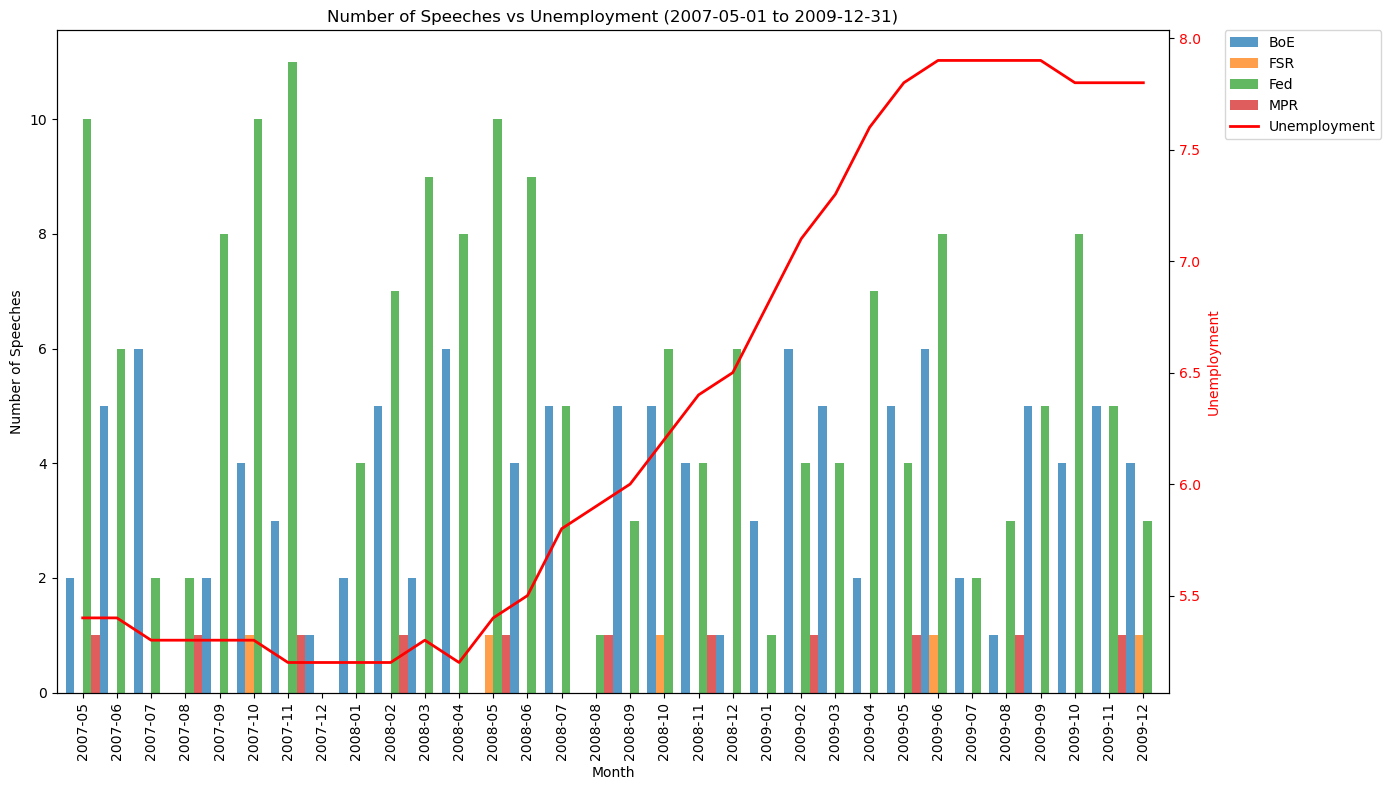

In [22]:
# Plot speech frequency with unemployment data for GFC period
plot_speeches_vs(dates_long, '2007-05-01', '2009-12-31', monthly_unemployment)

In [25]:
# Load the py_sentiment data
# As the text is unimportant for this purpose and file is 50mb
# Only keep the polarity and save
# Commented out and loaded saved file back in
#py = pd.read_csv('pysentiment2_scores.csv')
#sentiment = pd.DataFrame({'Date': py['date'], 'Polarity': py['lm_polarity']})
#sentiment.head()# Assuming 'sentiment' is your DataFrame
#sentiment.to_csv('sentiment.csv', index=False)

sentiment = pd.read_csv('sentiment.csv')
sentiment.head()

,Date,Polarity
0,1998-09-15,-0.418182
1,1998-10-21,-0.100529
2,1998-10-21,-0.372549
3,1998-11-01,-0.142857
4,1998-11-01,-0.406593


In [26]:
# Format the data
sentiment['Date'] = pd.to_datetime(unemployment['Date'])
sentiment['YearMonth'] = unemployment['Date'].dt.to_period('M')

# Aggregate data by month (if there are multiple entries per month)
monthly_sentiment = sentiment.groupby('YearMonth')['Polarity'].mean().reset_index()

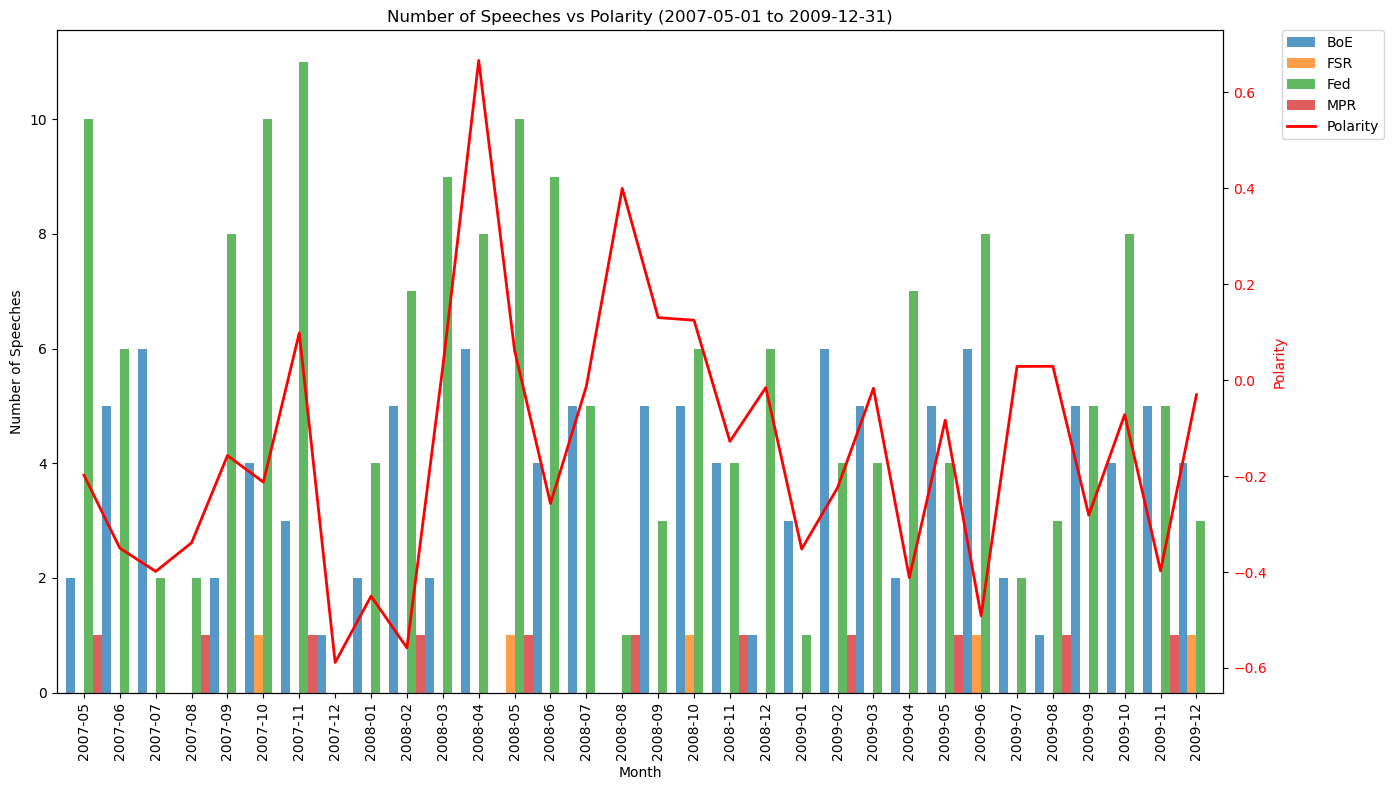

In [27]:
plot_speeches_vs(dates_long, '2007-05-01', '2009-12-31', monthly_sentiment)

In [28]:
print(dates_long.head())
print(dates_long.info())

  Meeting Type       Date  Type Code
0          BoE 1998-09-15          1
1          BoE 1998-10-21          1
2          BoE 1998-10-21          1
3          BoE 1998-11-01          1
4          BoE 1998-11-01          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6204 entries, 0 to 6203
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Meeting Type  6204 non-null   object        
 1   Date          2940 non-null   datetime64[ns]
 2   Type Code     6204 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 145.5+ KB
None


In [29]:
speeches_long = dates_long[dates_long['Meeting Type'].isin(['BoE', 'Fed'])]
print(speeches_long.head())
print(speeches_long.info())

  Meeting Type       Date  Type Code
0          BoE 1998-09-15          1
1          BoE 1998-10-21          1
2          BoE 1998-10-21          1
3          BoE 1998-11-01          1
4          BoE 1998-11-01          1
<class 'pandas.core.frame.DataFrame'>
Index: 3102 entries, 0 to 3101
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Meeting Type  3102 non-null   object        
 1   Date          2760 non-null   datetime64[ns]
 2   Type Code     3102 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 96.9+ KB
None


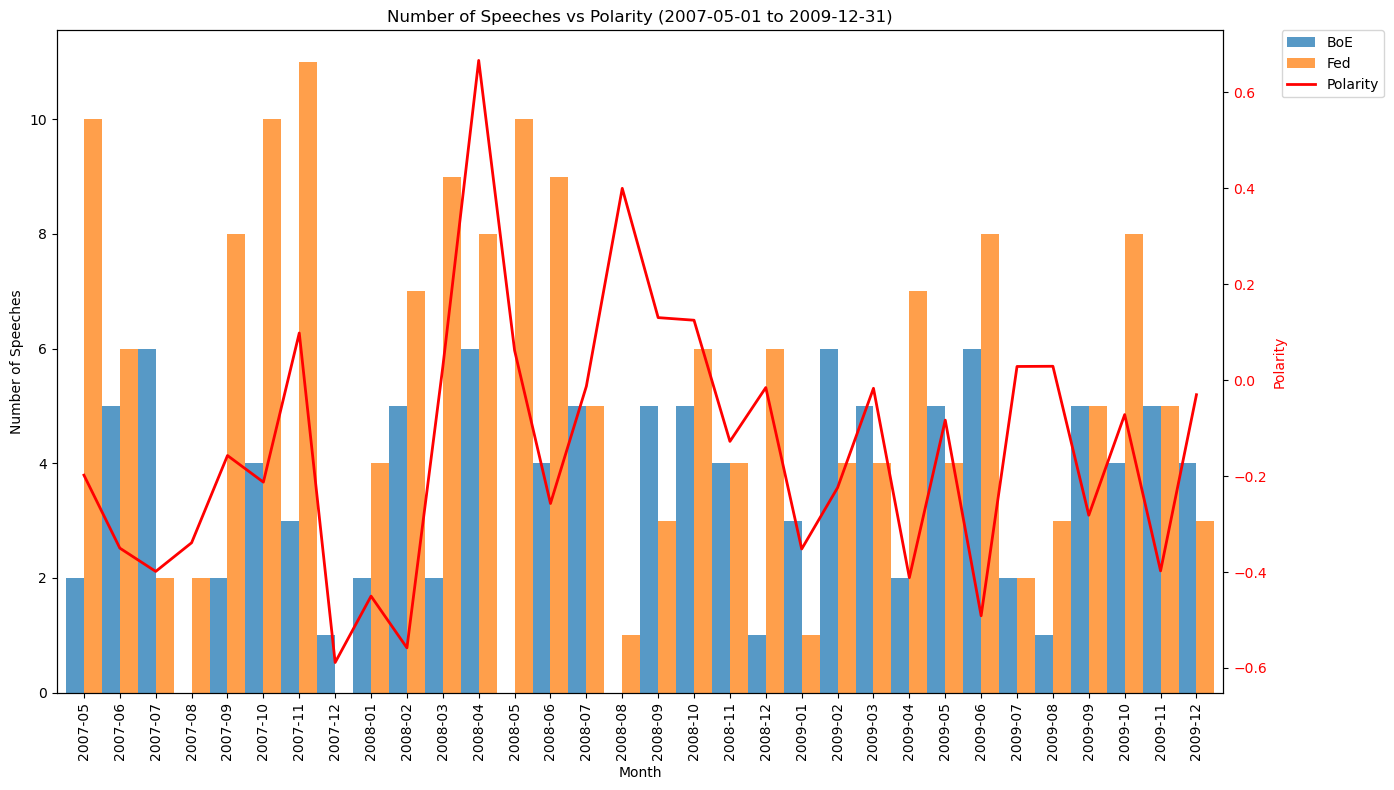

In [30]:
plot_speeches_vs(speeches_long, '2007-05-01', '2009-12-31', monthly_sentiment)

## Not explored further as speech frequency isn't a useful measure and we decided to look at polarity vs other measures on the same time-scale
